# Sparse Autoencoder based Feature Selection - Sequences Merged

### 1. Reading and Processing the stable radiomic features

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

import numpy as np

In [2]:
OUT_PATH=r"./results"
FEAT_PATH = r"./features_StudySettings3D.csv"
INT_ICC_PATH = r"./stability_study_results/INT_Clinical/inout_plane_systematic_features_StudySettings3D.csv"
EXT_ICC_PATH = r"./stability_study_results/QIN_NonClinical_Dependent/inout_plane_systematic_features_StudySettings3D.csv"

SEQUENCE_BESTFILTER_PREFIX = {
    
                "t2w":["original_shape","logarithm_firstorder","logarithm_glcm","logarithm_glszm","logarithm_glrlm","logarithm_gldm","logarithm_ngtdm"],
               
                "adc":["original_shape","log-sigma-5-0-mm-3D_firstorder","square_glcm","exponential_glszm","exponential_glrlm","exponential_gldm","exponential_ngtdm"],
                
                "dce_win":["original_shape","logarithm_firstorder","logarithm_glcm","wavelet-HLL_glszm","logarithm_glrlm","square_gldm","logarithm_ngtdm"],
                
                "dce_wout":["original_shape","logarithm_firstorder","logarithm_glcm","logarithm_glszm","logarithm_glrlm","logarithm_gldm","logarithm_ngtdm"]
                
               }

ICC_THRESHOLD = 0.90

In [3]:
feat_df = pd.read_csv(FEAT_PATH)
int_icc_df = pd.read_csv(INT_ICC_PATH, index_col=0)
ext_icc_df = pd.read_csv(EXT_ICC_PATH, index_col=0)

#### selecting the stable radiomics features

In [4]:
selected_feats = {}

for i, row_int  in int_icc_df.iterrows():
    
    feature, _, c_down_int, _, sequence = row_int
       
    row_ext = ext_icc_df[ext_icc_df.feature==feature][ext_icc_df.sequence==sequence.split("_")[0]]#this is because for internal set there is dce_win and dce_wout, but for external there is only dce
    
    _, _, c_down_ext, _, _ = row_ext.values[0].tolist()

    if c_down_int>=ICC_THRESHOLD and c_down_ext>=ICC_THRESHOLD:
    
        prefices = SEQUENCE_BESTFILTER_PREFIX[sequence]

        for prefix in prefices:

            if prefix in feature:
                selected_feats.setdefault(sequence,[]).append(feature)
                

c:\sithin\myenv\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


### 2. Merged Features of all the sequences

In [5]:
features = []

merged_df = {}

for sequence,feats in selected_feats.items():### 9. Compute Delta based on mean
    
    for feat in feats:
        features.append(sequence+"_"+feat)
        merged_df[sequence+"_"+feat] = feat_df[feat_df.sequence==sequence].sort_values(by=['id'])[feat].values

merged_df["label"] = feat_df[feat_df.sequence==sequence].sort_values(by=['id'])["label"].values
merged_df["id"] = feat_df[feat_df.sequence==sequence].sort_values(by=['id'])["id"].values
    
merged_df = pd.DataFrame.from_dict(merged_df)


### 3. Sort Features In an Orderly Way (Pearson correlation is dependent on that, Simple to Complex features)

In [6]:
def sort_feats(features):

    sorted_features = []

    for sequence in ["t2w","adc","dce_win","dce_wout"]:

        for feat_type in ["shape","firstorder","glcm","glszm","glrlm","gldm","ngtdm"]:

            feats = sorted([feat for feat in features if sequence in feat and feat_type in feat and feat not in sorted_features])

            sorted_features += feats
            
    return sorted_features
        

In [7]:
features = sort_feats(features)

In [8]:
len(features)

321

#### Class Distribution

In [9]:
merged_df["label"].value_counts()

0    69
1    31
Name: label, dtype: int64

<AxesSubplot:>

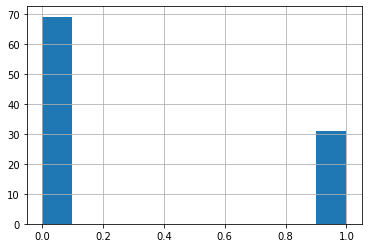

In [10]:
merged_df.label.hist()

### 4. Removing features with zero variance

In [11]:
var_threshold = 0.0

In [12]:
feats,var_tags = zip(*((merged_df[features].var()<=var_threshold).to_dict()).items())
low_variance_features = list(np.array(feats)[np.array(var_tags)])
features = list(set(features) - set(low_variance_features))
print(f"Removed {len(low_variance_features)}; {len(features)} remaining")

Removed 0; 321 remaining


In [13]:
features = sort_feats(features)

### 5. Shape and Volume Correlated Feature Filtering

In [14]:
R_THRESHOLD = 0.85

In [15]:
#Removing Features Correlated with Shape which includes volume features as well

to_drop = []
corr = merged_df[features].corr(method="pearson").abs()
corr_dict = corr.to_dict()

for feat in features:

    if "original_shape" in feat:

        _to_drop = [key for key,val in corr_dict[feat].items() if val>=R_THRESHOLD and key not in to_drop]
        to_drop += _to_drop

    
features = list(set(features)-set(to_drop))
print(f"{len(to_drop)} highly shape correlated features deleted, {len(features)} features remaining")


58 highly shape correlated features deleted, 263 features remaining


In [16]:
features = sort_feats(features)

### 6. Feature filtering using pearson correlation coefficient on the merged dataframe

Didn't do this because AE needs correlated features as input to effectively encode them

In [17]:
# R_THRESHOLD = 0.85

In [18]:
# corr = merged_df[features].corr(method="pearson").abs()#order matters actually here
# up_tri = corr.where(np.triu(np.ones(corr.shape),k=1).astype(bool))
# to_drop = [column for column in up_tri.columns if any(up_tri[column] >= R_THRESHOLD)]
# filtered_features = list(set(features)-set(to_drop))


# print(f"{len(to_drop)} highly correlated features deleted, {len(filtered_features)} features remaining")


In [19]:
# features = sort_feats(filtered_features)

#### Visualizing clusters using PCA and t-SNE

In [20]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [21]:
SEED = 0

In [22]:
def visualize(features, labels, n_components, sequence):
 
    features = features.copy()
    
    scaler = StandardScaler()#it is necessary to ensure that the scale is similar
    features = scaler.fit_transform(features)

    embedding = {}
    
    embedding["pca"] = PCA(n_components = n_components, random_state=SEED).fit_transform(features)
    embedding["tsne"] = TSNE(n_components=n_components,random_state=SEED).fit_transform(features)
        
    
    # initialising the plot
    
    fig = plt.figure()
    
    for i,key in enumerate(embedding.keys()):
    
        ax = fig.add_subplot(1,2,i+1,projection="3d")

        # plotting data
        ax.scatter(*zip(*embedding[key][np.where(labels==1)]),marker='o',color='r',s=10,alpha=0.7,label='Class-1')
        ax.scatter(*zip(*embedding[key][np.where(labels==0)]),marker='o',color='g',s=10,alpha=0.3,label='Class-0')
        ax.set_title(f"{sequence}-{key}")
        ax.legend()

    

    plt.show
    

c:\sithin\myenv\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
c:\sithin\myenv\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


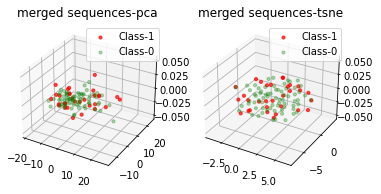

In [23]:
num_components = 2
  
feats = merged_df[features].to_numpy()
labels = merged_df["label"].to_numpy()
    
visualize(feats, labels, num_components,"merged sequences")

### 7. Defining AE Components

In [24]:
import time
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F

#### Dataset

In [25]:
class TensorDataset(torch.utils.data.Dataset):
    
    def __init__(self, X):
        
        self.X = X
        
    def __len__(self):
        
        return len(self.X)
    
    def __getitem__(self, i):
        
        X = self.X[i]

        return X
            
                  

#### Module and Utils

In [26]:
class Module(nn.Module):
    
    def __init__(self, input_dim, latent_dim=8):
        
        super(Module, self).__init__()
        
        self.encoder = nn.Sequential(*[
            nn.Linear(input_dim,latent_dim * 2**3), nn.ReLU(), 
            nn.Linear(latent_dim * 2**3 , latent_dim * 2**2 ), nn.ReLU(),
            nn.Linear(latent_dim * 2**2 ,latent_dim * 2), nn.ReLU(),
            nn.Linear(latent_dim * 2,latent_dim), nn.Sigmoid()
        ])
        
        self.decoder = nn.Sequential(*[
            nn.Linear(latent_dim, latent_dim * 2), nn.ReLU(),
            nn.Linear(latent_dim * 2 , latent_dim * 2**2), nn.ReLU(),
            nn.Linear(latent_dim * 2**2 ,latent_dim * 2**3), nn.ReLU(),
            nn.Linear(latent_dim * 2**3, input_dim)
            
        ])

        
    def forward(self, x):
        
        x = h = self.encoder(x)
        x = self.decoder(x)
        
        return h, x
        


In [27]:
class Model:
    
    def __init__(self,module):
        
        self.module = module
        
    def compile(self, lr, h_lambda, criterion, cuda_device_id=0):
        
        self.criterion = criterion
        self.h_lambda = h_lambda
        self.optimizer = torch.optim.AdamW(self.module.parameters(), lr)
        #self.device = torch.device(f'cuda:{cuda_device_id}' if torch.cuda.is_available() else "cpu")
        self.device = torch.device("cpu")
        self.module.to(self.device)
        
        return self.module
        
    def fit(self, dls, num_epochs,verbose=True):
        
        
        since = time.time()
        
        hist = {'train':{'loss':[]},'val':{'loss':[]}}
        
        best_model_wts = copy.deepcopy(self.module.state_dict())
        best_loss = np.inf
        
        for epoch in range(num_epochs):
            
            if verbose:
                
                print('Epoch {}/{}'.format(epoch,num_epochs-1))
                print('-'*10)
                
                
            for phase in ['train','val']:
  
                if phase=='train':
                    self.module.train()
                else:
                    self.module.eval()

                running_loss = 0.0
                
                for X in dls[phase]:
                    
                    X = X.to(self.device)
                    
                    self.optimizer.zero_grad()
                    
                    with torch.set_grad_enabled(phase=='train'):
                
                        h, _X = self.module(X)
    
                        loss = self.criterion(_X,X) + self.h_lambda * h.flatten().abs().sum()
                        
                      
                        if phase=='train':
                            loss.backward()
                            self.optimizer.step()
                
                            running_loss += loss.item() 
                        
                if phase=="train":
                    epoch_loss = running_loss/len(dls[phase])
                else:
                    epoch_loss = loss

                if verbose:
                    print("{} Loss :{:.4f}".format(phase,epoch_loss))
                    
                if torch.isnan(loss):
                    return

                hist[phase]['loss'].append(epoch_loss)

                if phase == "val":

                    if epoch_loss<best_loss:
                        best_loss = epoch_loss
                        best_model_wts = copy.deepcopy(self.module.state_dict())
                            
            if verbose:
                print()
            
    
        time_elapsed = time.time() - since

        if verbose:
            print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
            print('Best val Loss: {:4f}'.format(best_loss))

        self.module.load_state_dict(best_model_wts)

        return self.module.cpu(), best_loss
                    
        
        
    

In [28]:
def train_val_split(X,y):
    
    normal_indeces = np.argwhere(y==0).ravel()
    anomaly_indeces = np.argwhere(y==1).ravel()
    
    np.random.shuffle(normal_indeces)
    
    train_indeces = normal_indeces[:-len(anomaly_indeces)]
    val_indeces = normal_indeces[-len(anomaly_indeces):]
    test_indeces = np.concatenate([normal_indeces[-len(anomaly_indeces):],anomaly_indeces])
    
    X_train = X[train_indeces]
    y_train = y[train_indeces]
    
    X_val = X[val_indeces]
    y_val = y[val_indeces]
    
    X_test = X[test_indeces]
    y_test = y[test_indeces]
    
    return X_train,X_val,X_test, y_train,y_val, y_test
    

### 8. Feature Selection using AE

In [29]:
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

In [30]:
num_repeats = 100
batch_size = 32
criterion = nn.L1Loss()
latent_dim = 4
h_lambda = 1e-1
lr = 1e-2
num_epochs = 1000

In [31]:
out_path = os.path.join(OUT_PATH,"all_sequences")
if not os.path.exists(out_path):
    os.makedirs(out_path)
    
if os.path.exists(os.path.join(out_path,"exe_stat.npy")):
    exe_stat = np.load(os.path.join(out_path,"exe_stat.npy"),allow_pickle=True).item()
else:
    exe_stat = {}

In [32]:
if not os.path.exists(os.path.join(out_path,"recon_df.csv")):

    print(f"Running experiments for merged sequences")
    
    columns = ["recon_err_"+feat_name for feat_name in features] + ["recon_err_mean", "label", "repeat_id"]
    recon_df = {column:[] for column in columns}
    
    scaler = MinMaxScaler()

    X = merged_df[features].to_numpy()
    y = merged_df["label"].to_numpy()
    

    start_time = time.time()
    for n in tqdm(range(num_repeats),desc="Repeat Progress"):
        
        X_train, X_val, X_test, y_train, y_val, y_test = train_val_split(X,y)
        
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)
        X_test = scaler.transform(X_test)

        X_train = torch.from_numpy(X_train).float()
        X_val = torch.from_numpy(X_val).float()
        X_test = torch.from_numpy(X_test).float()
        
        y_test = torch.from_numpy(y_test).int()#storing labels

        train_ds = TensorDataset(X_train)
        train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)

        dls = {"train":train_dl, "val":[X_val]}

        in_dim = X.shape[1]

        #print(f"Repeat:{i}/{num_repeats}\n")
        module = Module(in_dim, latent_dim)
        model = Model(module)

        model.compile(lr, h_lambda, criterion)
        best_module, loss = model.fit(dls,num_epochs,verbose=False)

        h, _X_test = best_module(X_test)

        recon_errs = torch.abs((X_test - _X_test))
        
        for i,feat in enumerate(features):
            recon_df["recon_err_"+feat] += list(recon_errs[:,i].detach().numpy())
        recon_df["recon_err_mean"] += list(recon_errs.mean(1).detach().numpy())
        recon_df["label"] += list(y_test.detach().numpy())
        recon_df["repeat_id"] += [n] * len(y_test)


    recon_df = pd.DataFrame.from_dict(recon_df)
    recon_df.to_csv(os.path.join(out_path,"recon_df.csv"),index=False)
    
    exe_stat["autoencoder"] = (time.time() - start_time)
    np.save(os.path.join(out_path,"exe_stat.npy"),exe_stat)
    
else:
    recon_df = pd.read_csv(os.path.join(out_path,"recon_df.csv"))

exe_time = exe_stat["autoencoder"]
    
print(f"Autoencoder => Execution Time:{exe_time}")
    

Autoencoder => Execution Time:782.7470002174377


#### Mean reconstruction error boxplot

<AxesSubplot:xlabel='label', ylabel='recon_err_mean'>

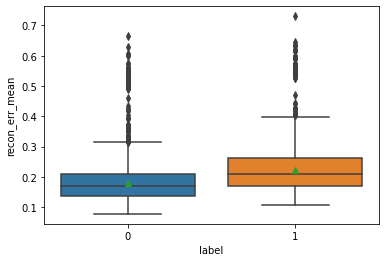

In [33]:
sns.boxplot(x='label',y="recon_err_mean",data=recon_df, showfliers=True,showmeans=True)
#sns.swarmplot(x="label", y="recon_err_mean", data=recon_df, color="0.25")

<AxesSubplot:xlabel='label', ylabel='recon_err_mean'>

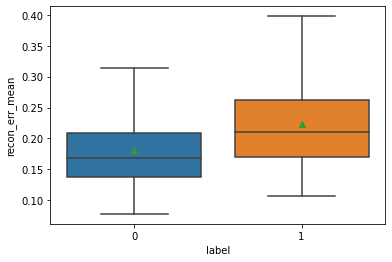

In [34]:
sns.boxplot(x='label',y="recon_err_mean",data=recon_df, showfliers=False,showmeans=True)

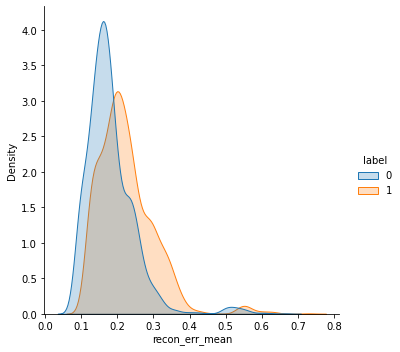

In [35]:
sns.displot(data=recon_df,x="recon_err_mean", hue="label", kind="kde", fill=True)

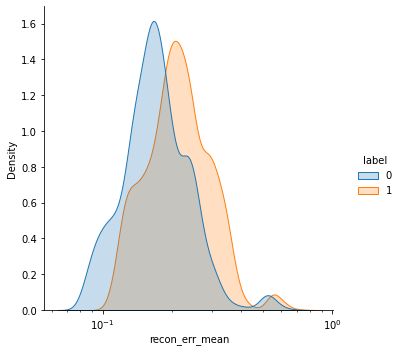

In [36]:
sns.displot(data=recon_df,x="recon_err_mean", hue="label", kind="kde", fill=True, log_scale=True)

### 9. Compute Delta based on the difference of the mean reconstruction error grouped by label

In [37]:
temp_df = recon_df.copy()
temp_df = temp_df.groupby(by="label").mean()

print(temp_df["recon_err_mean"].to_dict())

temp_df.pop("recon_err_mean")
temp_df.pop("repeat_id")

delta = temp_df.loc[1]-temp_df.loc[0]
delta = dict(sorted(delta.items(), key=lambda item: item[1],reverse=True)) # soring the delta value

{0: 0.18122150485548386, 1: 0.2239901567751613}


### 10. Removing Correlated Features in Delta

In [38]:
R_THRESHOLD = 0.85

features,_ = zip(*delta.items())#essentially getting the ordered features based on the delta value
features = [feat.replace("recon_err_","") for feat in list(features)]

corr = merged_df[features].corr(method="pearson").abs()#order matters actually here
up_tri = corr.where(np.triu(np.ones(corr.shape),k=1).astype(bool))
to_drop = [column for column in up_tri.columns if any(up_tri[column] >= R_THRESHOLD)]
filtered_features = list(set(features)-set(to_drop)) #set operation can cause the list to loose the order


print(f"{len(to_drop)} highly correlated features deleted, {len(filtered_features)} features remaining")


204 highly correlated features deleted, 59 features remaining


#### Delta after removing correlated features

In [39]:
delta_filtered = {}

for feat in filtered_features:
    delta_filtered[feat] = delta["recon_err_"+feat]

delta_filtered = dict(sorted(delta_filtered.items(), key=lambda item: item[1],reverse=True)) #sorting based on delta value

In [40]:
60/428

0.14018691588785046

In [41]:
for sequence in ["t2w","adc","dce_win","dce_wout"]:
    
    _features = [feat for feat in filtered_features if sequence in feat]
    
    print(sequence, len(_features))

t2w 11
adc 16
dce_win 17
dce_wout 15


#### Visualizing top 10 features

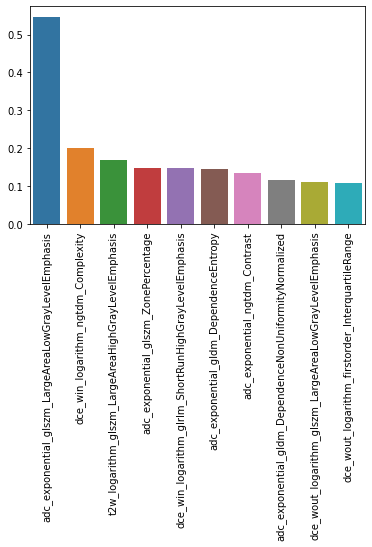

In [42]:
%matplotlib inline
x,y = zip(*delta_filtered.items())

sns.barplot(x=list(x)[:10],y=list(y)[:10])
plt.xticks(rotation=90)
plt.show()


### 11. Generating the ranks using filtered delta value

In [43]:
rank_df = {}

rank_df["feature"] = []
rank_df["delta"] = []
rank_df["rank"] = []

i = 1
for key,value in delta_filtered.items():
    
    rank_df["feature"].append(key)
    rank_df["delta"].append(value)
    rank_df["rank"].append(i)
    
    i += 1
    
rank_df = pd.DataFrame.from_dict(rank_df)

rank_df.to_csv(os.path.join(out_path,"autoencoder.csv"),index=False)


#### Visualizing Top 10 radiomics features

In [44]:
rank_df.head(10)

,feature,delta,rank
0,adc_exponential_glszm_LargeAreaLowGrayLevelEmp...,0.547377,1
1,dce_win_logarithm_ngtdm_Complexity,0.198732,2
2,t2w_logarithm_glszm_LargeAreaHighGrayLevelEmph...,0.167528,3
3,adc_exponential_glszm_ZonePercentage,0.148363,4
4,dce_win_logarithm_glrlm_ShortRunHighGrayLevelE...,0.146037,5
5,adc_exponential_gldm_DependenceEntropy,0.144978,6
6,adc_exponential_ngtdm_Contrast,0.134904,7
7,adc_exponential_gldm_DependenceNonUniformityNo...,0.114790,8
8,dce_wout_logarithm_glszm_LargeAreaLowGrayLevel...,0.111378,9
9,dce_wout_logarithm_firstorder_InterquartileRange,0.106863,10


#### Radiomics Signature

In [45]:
NUM_FEATS = 4
radiomics_signature = rank_df.feature.to_list()[:NUM_FEATS]

radiomics_signature 

['adc_exponential_glszm_LargeAreaLowGrayLevelEmphasis',
 'dce_win_logarithm_ngtdm_Complexity',
 't2w_logarithm_glszm_LargeAreaHighGrayLevelEmphasis',
 'adc_exponential_glszm_ZonePercentage']

In [46]:
if os.path.exists(os.path.join(OUT_PATH,"signatures_merged.csv")):
    signatures = pd.read_csv(os.path.join(OUT_PATH,"signatures_merged.csv"))
else:
    signatures = pd.DataFrame.from_dict({})
    
signatures["AE_LogisticRegression"] = radiomics_signature
signatures["AE_SVC"]=radiomics_signature
signatures["AE_RandomForestClassifier"]=radiomics_signature

signatures.to_csv(os.path.join(OUT_PATH,"signatures_merged.csv"),index=False)

### 12. ML pipeline for Singature Validation

Linear Model: LogisticRegression

Non Linear Model: RandomForestClassifier, SVM(rbf)

In [47]:
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)#because of xgboost warnings

In [48]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
#import xgboost as xgb

In [49]:
rskf = RepeatedStratifiedKFold(n_splits=3, n_repeats=100,random_state=0)
estimators = [
    LogisticRegression(penalty='none'),
    SVC(),
    RandomForestClassifier()
]


In [50]:
for estimator in estimators:

    X = merged_df[radiomics_signature].to_numpy()
    y = merged_df["label"].to_numpy().ravel()

    estimator_pipeline = make_pipeline(StandardScaler(),estimator)
    results = cross_validate(estimator_pipeline,X,y,scoring=["roc_auc"],verbose=1,cv=rskf)

    roc_auc = results["test_roc_auc"]

    print(f"Estimator:{estimator.__class__.__name__}, roc_auc:{roc_auc.mean():0.2}+-{roc_auc.std():0.2}")


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Estimator:LogisticRegression, roc_auc:0.71+-0.096


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Estimator:SVC, roc_auc:0.74+-0.072
Estimator:RandomForestClassifier, roc_auc:0.73+-0.079


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   52.3s finished


# Permutation Test

In [51]:
from sklearn.model_selection import permutation_test_score

In [56]:
export_path = r"C:\Sithin\autoencoder\permutation_results\merged-sequence"
if not os.path.exists(export_path):
    os.makedirs(export_path)

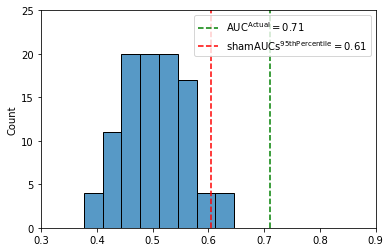

Estimator:LogisticRegression, Actual roc-auc: 0.7111805006587616, Range of sham roc-aucs:((0.37698155467720684, 0.6464137022397892)), p-value:0.009900990099009901, Distance:0.1061485507246378


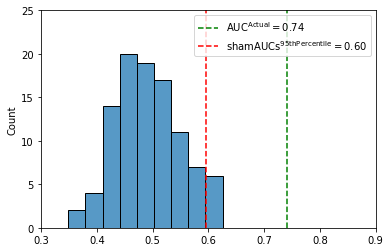

Estimator:SVC, Actual roc-auc: 0.7417272727272728, Range of sham roc-aucs:((0.34895388669301713, 0.6254743083003953)), p-value:0.009900990099009901, Distance:0.14583590250329392


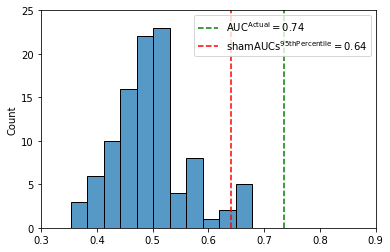

Estimator:RandomForestClassifier, Actual roc-auc: 0.7352483530961791, Range of sham roc-aucs:((0.35300790513833996, 0.6782720685111989)), p-value:0.009900990099009901, Distance:0.09489219367588919


In [57]:
if not os.path.exists(os.path.join(out_path,"ae_permutation_test.npy")):
    results = {}
    for estimator in estimators:
    
        radiomics_signature = signatures["AE_"+estimator.__class__.__name__].to_list()

        X = merged_df[radiomics_signature]
        y = merged_df["label"].to_numpy().ravel()

        estimator_pipeline = make_pipeline(StandardScaler(), estimator)
        mean_rocauc, permuted_rocaucs, p_value = permutation_test_score(estimator_pipeline, X, y, scoring="roc_auc",verbose=1,cv=rskf)

        results[estimator.__class__.__name__] = {"p_value":p_value,"mean_auc":mean_rocauc,"permuted_aucs":permuted_rocaucs}
        
    np.save(os.path.join(out_path,"ae_permutation_test.npy"),results)
    
else:
    results = np.load(os.path.join(out_path,"ae_permutation_test.npy"),allow_pickle=True).item()
    

# for estimator in results:
    
#     p_value = results[estimator]["p_value"]
#     mean_rocauc = results[estimator]["mean_auc"]
#     permuted_rocaucs = results[estimator]["permuted_aucs"]
    
#     sns.histplot(permuted_rocaucs)
#     plt.axvline(mean_rocauc)
#     plt.show()

#     distance = mean_rocauc - np.percentile(permuted_rocaucs, 95)

#     print(f"Estimator:{estimator.__class__.__name__}, Actual roc-auc: {mean_rocauc}, Range of sham roc-aucs:({min(permuted_rocaucs),max(permuted_rocaucs)}), p-value:{p_value}, Distance:{distance}")


for estimator in results:
    
    p_value = results[estimator]["p_value"]
    mean_rocauc = results[estimator]["mean_auc"]
    permuted_rocaucs = results[estimator]["permuted_aucs"]
    
    params = {'mathtext.default':'regular'}
    plt.rcParams.update(params)
    
    fig = plt.figure()
    ax = fig.gca()
    
    sns.histplot(permuted_rocaucs, ax=ax)
    ax.set_xlim(0.3,0.9)
    ax.set_ylim(0,25)
    plt.axvline(mean_rocauc, label="$AUC^{Actual}$"+f"$={mean_rocauc:0.2f}$", color='g', ls='--')
    
    percentile95 = np.percentile(permuted_rocaucs, 95)
    
    plt.axvline(percentile95, label="$shamAUCs^{95th Percentile}$"+f"$={percentile95:0.2f}$", color='r', ls='--')
    plt.legend(loc="upper right")
    plt.savefig(os.path.join(export_path,f"main-{estimator}.png"),dpi=300)
    plt.show()

    distance = mean_rocauc - percentile95#np.percentile(permuted_rocaucs, 95)
    
    

    print(f"Estimator:{estimator}, Actual roc-auc: {mean_rocauc}, Range of sham roc-aucs:({min(permuted_rocaucs),max(permuted_rocaucs)}), p-value:{p_value}, Distance:{distance}")
    




# Fun Experiments

### 1. Majority Voting

In [ ]:

repeat_ids = recon_df.repeat_id.unique()
temp_df = recon_df.groupby(by=["repeat_id","label"]).mean()
temp_df.pop("recon_err_mean")

votes = {}


for i in repeat_ids:
    
    delta_i = temp_df.loc[i,1] - temp_df.loc[i,0]
    delta_i = dict(sorted(delta_i.items(), key=lambda item: item[1],reverse=True)) # soring the delta value
    
    feats,recon_errs = zip(*delta_i.items())
    
    for v,feat in enumerate(feats):
        votes.setdefault(feat,[]).append(v+1)


votes_df = pd.DataFrame.from_dict(votes)

ranks= {"feature":[],"rank":[],"delta":[]}
for feat in votes_df.columns:
    
    ranks["feature"].append(feat.replace("recon_err_",""))
    ranks["rank"].append(max(votes_df[feat].mode()))
    ranks["delta"].append(delta[feat])
    


    
rank_df = pd.DataFrame.from_dict(ranks)  
rank_df = rank_df.sort_values(by=['rank','delta'],ascending=[True, False]).reset_index(drop=True)
    
    
# vote_df = pd.DataFrame.from_dict(vote_df)
# _=vote_df.pop("repeat_id")


In [ ]:
R_THRESHOLD = 0.85

features = rank_df.feature

corr = merged_df[features].corr(method="pearson").abs()#order matters actually here
up_tri = corr.where(np.triu(np.ones(corr.shape),k=1).astype(bool))
to_drop = [column for column in up_tri.columns if any(up_tri[column] >= R_THRESHOLD)]
filtered_features = list(set(features)-set(to_drop)) #set operation can cause the list to loose the order


print(f"{len(to_drop)} highly correlated features deleted, {len(filtered_features)} features remaining")


In [ ]:
rank_df_filtered = rank_df[rank_df.feature.isin(filtered_features)].sort_values(by=['rank',"delta"],ascending=[True, False]).reset_index(drop=True)

In [ ]:
rank_df_filtered

In [ ]:
radiomics_signature = rank_df_filtered.feature.to_list()[:NUM_FEATS]

radiomics_signature

In [ ]:
for estimator in estimators:

    X = merged_df[radiomics_signature].to_numpy()
    y = merged_df["label"].to_numpy().ravel()

    estimator_pipeline = make_pipeline(StandardScaler(),estimator)
    results = cross_validate(estimator_pipeline,X,y,scoring=["roc_auc"],verbose=1,cv=rskf)

    roc_auc = results["test_roc_auc"]

    print(f"Estimator:{estimator.__class__.__name__}, roc_auc:{roc_auc.mean():0.2}+-{roc_auc.std():0.2}")


### 1. Using wasserstein distance instead of delta

In [ ]:
from scipy.stats import wasserstein_distance

In [ ]:
distance = {}

In [ ]:
for feat in features:
    
    U = recon_df["recon_err_"+feat][recon_df.label==0].values
    V = recon_df["recon_err_"+feat][recon_df.label==1].values
    
    distance[feat] = wasserstein_distance(U,V)

In [ ]:
distance = dict(sorted(distance.items(), key=lambda item: item[1],reverse=True))

In [ ]:
R_THRESHOLD = 0.85

features,_ = zip(*distance.items())#essentially getting the ordered features based on the delta value
features = [feat.replace("recon_err_","") for feat in list(features)]

corr = merged_df[features].corr(method="pearson").abs()#order matters actually here
up_tri = corr.where(np.triu(np.ones(corr.shape),k=1).astype(bool))
to_drop = [column for column in up_tri.columns if any(up_tri[column] >= R_THRESHOLD)]
filtered_features = list(set(features)-set(to_drop))


print(f"{len(to_drop)} highly correlated features deleted, {len(filtered_features)} features remaining")


In [ ]:
distance_filtered = {}

for feat in filtered_features:
    distance_filtered[feat] = distance[feat]

distance_filtered = dict(sorted(distance_filtered.items(), key=lambda item: item[1],reverse=True))

In [ ]:
%matplotlib inline
sns.barplot(x=list(distance_filtered.keys())[:10],y=list(distance_filtered.values())[:10])
plt.xticks(rotation=90)
plt.show()


In [ ]:
NUM_FEATS = 4
radiomics_signature = [key for key in list(distance_filtered.keys())[:NUM_FEATS]]

radiomics_signature

In [ ]:
for estimator in estimators:

    X = merged_df[radiomics_signature].to_numpy()
    y = merged_df["label"].to_numpy().ravel()

    estimator_pipeline = make_pipeline(StandardScaler(),estimator)
    results = cross_validate(estimator_pipeline,X,y,scoring=["roc_auc"],verbose=1,cv=rskf)

    roc_auc = results["test_roc_auc"]

    print(f"Estimator:{estimator.__class__.__name__}, roc_auc:{roc_auc.mean():0.2}+-{roc_auc.std():0.2}")
